In [1]:
import numpy as np
import sys
import datasets
from transformers import AutoTokenizer
sys.path.append("..")
from babilong_utils import TaskDataset, SentenceSampler, NoiseInjectionDataset

/home/jovyan/envs/3accel_rmt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ### extract dataset archive
# !unzip ../data/tasks_1-20_v1-2.zip -d ../data/

In [3]:
# train_path = "../data/tasks_1-20_v1-2/en-10k/qa4_two-arg-relations_train.txt"
# test_path = "../data/tasks_1-20_v1-2/en-10k/qa4_two-arg-relations_test.txt"

# train_path = "../data/tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_train.txt"
# test_path = "../data/tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_test.txt"

# train_path = "../data/tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_train.txt"
# test_path = "../data/tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_test.txt"

train_path = "../data/tasks_1-20_v1-2/en-10k/qa3_three-supporting-facts_train.txt"
test_path = "../data/tasks_1-20_v1-2/en-10k/qa3_three-supporting-facts_test.txt"

# train_path = "../data/tasks_1-20_v1-2/en-10k/qa5_three-arg-relations_train.txt"
# test_path = "../data/tasks_1-20_v1-2/en-10k/qa5_three-arg-relations_test.txt"

noise_dataset = datasets.load_dataset("pg19")

/home/jovyan/envs/3accel_rmt/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for pg19 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/pg19
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


### Load task datasets

In [60]:
# task 
# max_n_facts = 512 // 10
max_n_facts = 16
task_dataset_train = TaskDataset(train_path, max_n_facts=max_n_facts)
task_dataset_test = TaskDataset(test_path, max_n_facts=max_n_facts)

In [83]:
# background text
tokenizer = AutoTokenizer.from_pretrained('gpt2')

noise_sampler_train = SentenceSampler(noise_dataset['train'], tokenizer=tokenizer)
noise_sampler_test = SentenceSampler(noise_dataset['test'], tokenizer=tokenizer)

In [93]:
max_n_segments = 2
segment_size = 512               # max number of tokens in sample
qa_margin = 20
sample_size = max_n_segments * segment_size - qa_margin
# sample_size = 0
dataset_train = NoiseInjectionDataset(task_dataset=task_dataset_train,
                                        noise_sampler=noise_sampler_train,
                                        tokenizer=tokenizer,
                                        sample_size=sample_size,
                                        task_start_pct=0.5,
                                        task_end_pct=1
                                        )

dataset_test = NoiseInjectionDataset(task_dataset=task_dataset_test,
                                        noise_sampler=noise_sampler_test,
                                        tokenizer=tokenizer,
                                        sample_size=sample_size,
                                        task_start_pct=0,
                                        task_end_pct=0.5
                                        )

In [94]:
def get_reference_positions(sample):
    input_text = tokenizer.decode(sample['input_tokens'])
    reference_positions = []
    for f in sample['references']:
        ind = input_text.index(f) 
        text = input_text
        rel_ind = ind
        while True:
            text = text[rel_ind + 1:]
            if f not in text:
                break
            rel_ind = text.index(f)
            ind += rel_ind

        reference_positions.append((ind, ind + len(f)))
    
    return reference_positions

In [95]:
sample = dataset_test[0]

### collate function

In [96]:
import torch
from torch.nn.utils.rnn import pad_sequence

In [97]:
id_pad_value = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
gen_token = tokenizer.encode('GEN')[0]
eos_token = tokenizer.eos_token_id

def collate_fn(batch):
    targets = [torch.tensor(b['target_tokens']) for b in batch]
    input_ids = [torch.tensor(b['input_tokens'] + b['question_tokens'] + [gen_token] + b['target_tokens'] + [eos_token]) for b in batch]
    gen_inputs = [torch.tensor(b['input_tokens'] + b['question_tokens'] + [gen_token]) for b in batch]

    attention_mask = [torch.ones_like(b, dtype=int) for b in input_ids]
    labels_mask = [torch.zeros_like(b, dtype=bool) for b in input_ids]
    for m, t in zip(labels_mask, targets):
        m[-len(t) - 2:] = True

    input_ids = pad_sequence(input_ids, padding_value=id_pad_value, batch_first=True)
    gen_inputs = pad_sequence(gen_inputs, padding_value=id_pad_value, batch_first=True)
    attention_mask = pad_sequence(attention_mask, padding_value=0, batch_first=True)
    labels_mask = pad_sequence(labels_mask, padding_value=0, batch_first=True)

    collated = {}
    collated['input_ids'] = collated['labels'] = input_ids
    collated['input_ids_generate'] = gen_inputs
    collated['labels_mask'] = labels_mask
    collated['attention_mask'] = attention_mask.bool()
    collated['attention_mask_generate'] = (gen_inputs != id_pad_value).bool()
    collated['target_text'] = [b['answer'] for b in batch]
    return collated

In [98]:
batch = [dataset_train[i] for i in range(10)]

In [99]:
collated = collate_fn(batch)

### test a model

In [53]:
from transformers import AutoModelForCausalLM
from modeling_rmt.language_modeling import MemoryCell, RecurrentWrapper
from modeling_rmt.experimental import MemoryCellGenerate

In [54]:
model = AutoModelForCausalLM.from_pretrained('gpt2')
cell = MemoryCellGenerate(model, num_mem_tokens=16)
model = RecurrentWrapper(cell, 
                        segment_size=512,
                        max_n_segments=2, 
                        segment_alignment=None,
                        k2=-1,
)
                            

base_model = AutoModelForCausalLM.from_pretrained('gpt2')
base_cell = MemoryCellGenerate(base_model, num_mem_tokens=0)
baseline = RecurrentWrapper(base_cell, 
                        segment_size=1024,
                        max_n_segments=1, 
                        segment_alignment=None,
                        k2=-1,
)
                            

In [35]:
# !ls /home/jovyan/rmt/runs/babilong/qa3_three-supporting-facts/gpt2/linear_adamw_wd1e-03_1x1024_mem0_bs64_bptt--1_from_cpt_0-1

In [55]:
baseline.memory_cell.memory = torch.nn.Parameter(torch.zeros(0))

In [56]:
# load cpt of rmt
cpt_path = "/home/jovyan/rmt/runs/babilong/qa3_three-supporting-facts/gpt2/linear_adamw_wd1e-03_2x512_mem16_bs64_bptt--1_from_cpt_1-2/run_5/model_best/pytorch_model.bin"
cpt = torch.load(cpt_path, map_location='cpu')
model.load_state_dict(cpt, strict=False)

## load cpt of base
cpt_path = "/home/jovyan/rmt/runs/babilong/qa3_three-supporting-facts/gpt2/linear_adamw_wd1e-03_1x1024_mem0_bs64_bptt--1_from_cpt_0-1/run_2/model_best/pytorch_model.bin"
cpt = torch.load(cpt_path, map_location='cpu')
baseline.load_state_dict(cpt, strict=False)

<All keys matched successfully>

In [57]:
# input_ids_generate = collated.pop('input_ids_generate')
# attention_mask_generate = collated.pop('attention_mask_generate')
# target_text = collated.pop('target_text')

In [39]:
# !nvidia-smi

In [58]:
device = 'cuda:3'
baseline.to(device=device)
model.to(device=device)
1

1

### Run evaluation

In [100]:
bs = 16
inputs = []
predictions = []
base_predictions = []
targets = []
all_reference_positions = []
all_input_lens = []
# for _ in range(3):
for bi in range(0, len(dataset_test) - bs, bs):
    batch = [dataset_test[i] for i in range(bi, bi+bs)]

    all_input_lens += [len(tokenizer.decode(s['input_tokens'])) for s in batch]
    all_reference_positions += [get_reference_positions(s) for s in batch]

    collated = collate_fn(batch)
    input_ids_generate = collated.pop('input_ids_generate').to(device)
    inputs.append(input_ids_generate)
    attention_mask_generate = collated.pop('attention_mask_generate').to(device)
    target_text = collated.pop('target_text')

    baseline_preds = baseline.generate(input_ids_generate, attention_mask=attention_mask_generate, pad_token_id=tokenizer.eos_token_id)
    preds = model.generate(input_ids_generate, attention_mask=attention_mask_generate, pad_token_id=tokenizer.eos_token_id)
    labels = [c[m] for c, m in zip(collated['input_ids'], collated['labels_mask'])]

    predictions.append(preds.cpu().detach())
    base_predictions.append(baseline_preds.cpu().detach())
    targets = targets + labels

/home/jovyan/envs/3accel_rmt/lib/python3.10/site-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [101]:
predictions = torch.cat(predictions, dim=0)
base_predictions = torch.cat(base_predictions, dim=0)

In [102]:
inputs = torch.cat(inputs, dim=0)
target_texts = np.array(tokenizer.batch_decode([t[1:-1] for t in targets]))


pred_texts = tokenizer.batch_decode(predictions[:, 1:-1], add_special_tokens=False)
pred_texts = np.array([t[:t.index("<|endoftext|>")] if "<|endoftext|>" in t else t for t in pred_texts])

pred_texts_base = tokenizer.batch_decode(base_predictions[:, 1:-1], add_special_tokens=False)
pred_texts_base = np.array([t[:t.index("<|endoftext|>")] if "<|endoftext|>" in t else t for t in pred_texts_base])

In [103]:
# facts in first half, max 16 facts
print(f"RMT acc: {(pred_texts == target_texts).mean()}\nBaseline acc: {(pred_texts_base == target_texts).mean()}")

RMT acc: 0.9375
Baseline acc: 1.0


In [ ]:
# facts in second half, max 16 facts
print(f"RMT acc: {(pred_texts == target_texts).mean()}\nBaseline acc: {(pred_texts_base == target_texts).mean()}")

RMT acc: 1.0
Baseline acc: 1.0


In [ ]:
# facts in 4th quarter, max 16 facts
print(f"RMT acc: {(pred_texts == target_texts).mean()}\nBaseline acc: {(pred_texts_base == target_texts).mean()}")

RMT acc: 0.9875
Baseline acc: 1.0


In [ ]:
# facts in third quarter, max 16 facts
print(f"RMT acc: {(pred_texts == target_texts).mean()}\nBaseline acc: {(pred_texts_base == target_texts).mean()}")

RMT acc: 0.9875
Baseline acc: 1.0


In [ ]:
# facts in second half, max 32 facts
print(f"RMT acc: {(pred_texts == target_texts).mean()}\nBaseline acc: {(pred_texts_base == target_texts).mean()}")

RMT acc: 0.9791666666666666
Baseline acc: 0.9826388888888888


In [ ]:
# facts in 0-1024, max 32 facts
print(f"RMT acc: {(pred_texts == target_texts).mean()}\nBaseline acc: {(pred_texts_base == target_texts).mean()}")

RMT acc: 0.9131944444444444
Baseline acc: 0.9826388888888888


In [ ]:
# max 128 facts other noise 2
print(f"RMT acc: {(pred_texts == target_texts).mean()}\nBaseline acc: {(pred_texts_base == target_texts).mean()}")

RMT acc: 0.9465277777777777
Baseline acc: 0.9704861111111112


In [ ]:
# max 128 facts other noise 2
print(f"RMT acc: {(pred_texts == target_texts).mean()}\nBaseline acc: {(pred_texts_base == target_texts).mean()}")

RMT acc: 0.9479166666666666
Baseline acc: 0.965625


In [ ]:
# max 128 facts other noise
print(f"RMT acc: {(pred_texts == target_texts).mean()}\nBaseline acc: {(pred_texts_base == target_texts).mean()}")

RMT acc: 0.9375
Baseline acc: 0.9677083333333333


In [ ]:
# max 128 facts
print(f"RMT acc: {(pred_texts == target_texts).mean()}\nBaseline acc: {(pred_texts_base == target_texts).mean()}")

RMT acc: 0.9412371134020618
Baseline acc: 0.9690721649484536


In [ ]:
# max 20 facts
print(f"RMT acc: {(pred_texts == target_texts).mean()}\nBaseline acc: {(pred_texts_base == target_texts).mean()}")

RMT acc: 0.9153846153846154
Baseline acc: 0.9923076923076923


In [46]:
error_inds = np.where(pred_texts != target_texts)[0]
error_inds_base = np.where(pred_texts_base != target_texts)[0]
error_inds

array([  0,  10,  22,  68,  97, 109, 110, 125, 184, 245, 273, 275, 388,
       493, 536, 562, 563, 566, 580, 581, 587, 592, 642, 659, 685, 702,
       708, 712, 774, 780, 782, 791, 793, 794, 797, 820, 821, 822, 839,
       844, 846, 850, 856, 861, 895, 904, 917, 938, 940, 951])

In [94]:
rmt_wins = [i for i in error_inds_base if i not in error_inds]
rmt_loses = [i for i in error_inds if i not in error_inds_base]
both_lose = [i for i in error_inds_base if i in error_inds]
both_win = [i for i in range(len(pred_texts_base)) if i not in error_inds_base if i not in error_inds]

In [95]:
len(rmt_wins), len(rmt_loses), len(both_win), len(both_lose)

(14, 31, 2816, 19)

In [96]:
all_input_lens[0]

3777

### Analyze fact positions

In [97]:
from matplotlib import pyplot as plt

In [98]:
rmt_wins_fact_positions = [[t[0] / all_input_lens[i] for t in all_reference_positions[i]] for i in rmt_wins]
rmt_loses_fact_positions = [[t[0] / all_input_lens[i] for t in all_reference_positions[i]] for i in rmt_loses]
both_win_fact_positions = [[t[0] / all_input_lens[i] for t in all_reference_positions[i]] for i in both_win]
both_lose_fact_positions = [[t[0] / all_input_lens[i] for t in all_reference_positions[i]] for i in both_lose]
all_fact_positions = [[t[0] / all_input_lens[i] for t in all_reference_positions[i]] for i in range(len(all_input_lens))]

In [99]:
# plt.hist([round(p, 5) for i in all_fact_positions for p in i], bins=15)


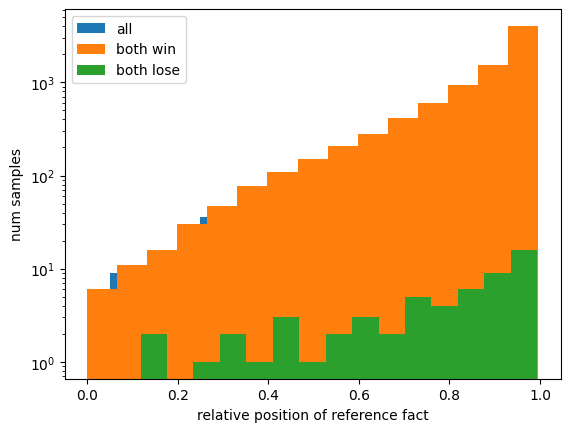

In [100]:

plt.hist([round(p, 5) for i in all_fact_positions for p in i], bins=20, density=False)
plt.hist([round(p, 5) for i in both_win_fact_positions for p in i], bins=15, density=False)
plt.hist([round(p, 5) for i in both_lose_fact_positions for p in i], bins=15, density=False)
plt.legend(['all', 'both win', 'both lose'])
plt.xlabel('relative position of reference fact')
plt.ylabel('num samples')
plt.yscale('log')
plt.show()

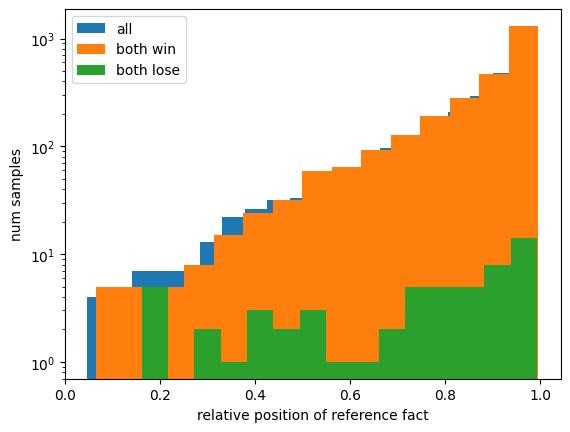

In [ ]:

plt.hist([round(p, 5) for i in all_fact_positions for p in i], bins=20, density=False)
plt.hist([round(p, 5) for i in both_win_fact_positions for p in i], bins=15, density=False)
plt.hist([round(p, 5) for i in both_lose_fact_positions for p in i], bins=15, density=False)
plt.legend(['all', 'both win', 'both lose'])
plt.xlabel('relative position of reference fact')
plt.ylabel('num samples')
plt.yscale('log')
plt.show()

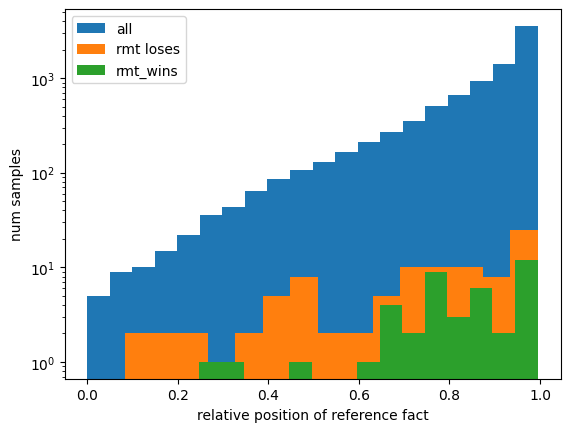

In [101]:

plt.hist([round(p, 5) for i in all_fact_positions for p in i], bins=20, density=False)
plt.hist([round(p, 5) for i in rmt_loses_fact_positions for p in i], bins=15, density=False)
plt.hist([round(p, 5) for i in rmt_wins_fact_positions for p in i], bins=15, density=False)
plt.legend(['all', 'rmt loses', 'rmt_wins'])
plt.xlabel('relative position of reference fact')
plt.ylabel('num samples')
plt.yscale('log')
plt.show()

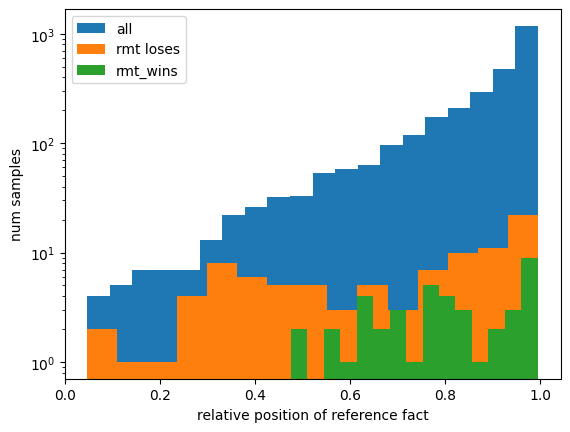

In [ ]:

plt.hist([round(p, 5) for i in all_fact_positions for p in i], bins=20, density=False)
plt.hist([round(p, 5) for i in rmt_loses_fact_positions for p in i], bins=15, density=False)
plt.hist([round(p, 5) for i in rmt_wins_fact_positions for p in i], bins=15, density=False)
plt.legend(['all', 'rmt loses', 'rmt_wins'])
plt.xlabel('relative position of reference fact')
plt.ylabel('num samples')
plt.yscale('log')
plt.show()

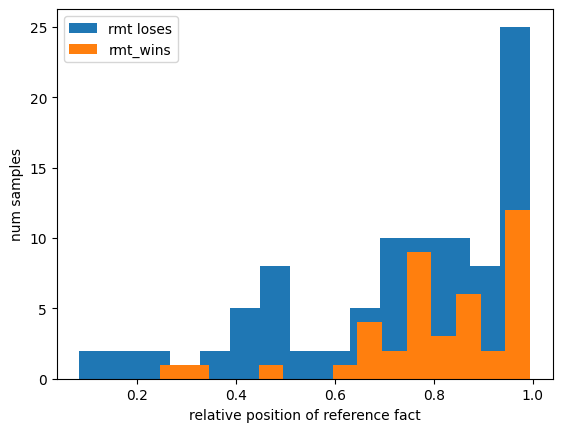

In [103]:

plt.hist([round(p, 5) for i in rmt_loses_fact_positions for p in i], bins=15)
plt.hist([round(p, 5) for i in rmt_wins_fact_positions for p in i], bins=15)
plt.legend(['rmt loses', 'rmt_wins'])
plt.xlabel('relative position of reference fact')
plt.ylabel('num samples')
plt.show()

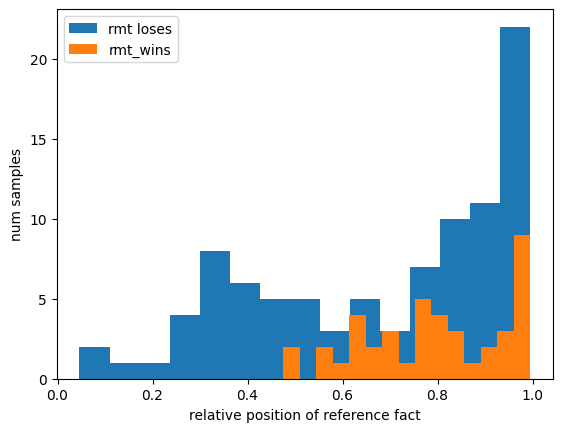

In [ ]:

plt.hist([round(p, 5) for i in rmt_loses_fact_positions for p in i], bins=15)
plt.hist([round(p, 5) for i in rmt_wins_fact_positions for p in i], bins=15)
plt.legend(['rmt loses', 'rmt_wins'])
plt.xlabel('relative position of reference fact')
plt.ylabel('num samples')
plt.show()

### why incline?


In [ ]:
samples = [dataset_test[i] for i in range(len(dataset_test))]
ref_pos_and_fact_nums = [(np.where([f in sample['references'] for f in sample['facts']])[0], len(sample['facts'])) for sample in samples]

Text(0.5, 0, 'relative reference fact number')

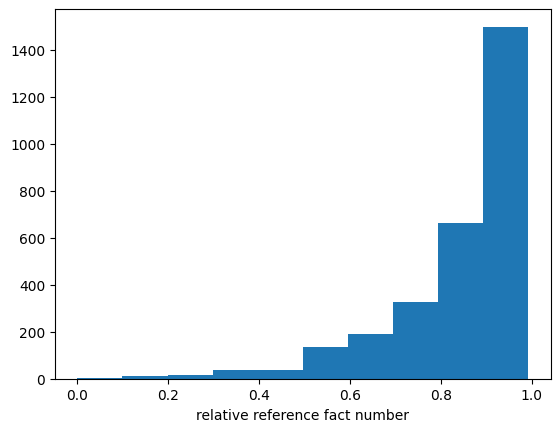

In [127]:

ref_pos = [x[0][-3:] for x in ref_pos_and_fact_nums]
fact_nums = [x[1] for x in ref_pos_and_fact_nums]

rel_ref_pos = [fp / x[1] for x in ref_pos_and_fact_nums for fp in x[0][-3:]]
plt.hist(rel_ref_pos)
plt.xlabel('relative reference fact number')

In [49]:
pred_texts[40]

'kitchen'

In [50]:
target_texts[40]

'kitchen'

In [45]:

for ind in rmt_wins:
    print('-' * 100)
    input_ids = torch.stack([inputs[ind]])
    segments = baseline.segment(input_ids=input_ids)

    for s in segments:
        text = tokenizer.batch_decode(s['input_ids'])[0]
        print("### Segment: ", text)
    print(f"RMT pred: {pred_texts[ind]}\nGPT pred: {pred_texts_base[ind]} gt: {target_texts[ind]}")


----------------------------------------------------------------------------------------------------
### Segment:  There were Robert, and Amy, and Louise, and Midgely--all making
for the Pullman cars in the rear.Mary got the milk.John moved to the bedroom.They had said their farewells to
their friends.Daniel journeyed to the office.John grabbed the apple there.A trio of assistants "gave a
hand" at getting the great wooden case into the car.John got the football.John journeyed to the garden.Jennie saw it
disappear with an acute physical wrench at her heart.There were many trunks to be put aboard, and then the door of the
baggage car half closed, but not before the warning bell of the engine
sounded.Mary left the milk.John left the football.Daniel moved to the garden.There was the insistent calling of "all aboard" from this
quarter and that; then slowly the great locomotive began to move.Daniel grabbed the football.Mary moved to the hallway.Its
bell was ringing, its steam hissing, its sm